<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval using GPT text embedding and CLIP image embedding for Wikipedia Articles

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex.

Wikipedia Text embedding index: Generate GPT text embeddings from OpenAI for texts

Wikipedia Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Query encoder:
* Encoder query text for text index using GPT embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts and images raw files for Wikipedia articles
2. Build text index for vector store using GPT embeddings
3. Build image index for vector store using CLIP embeddings
4. Retrieve relevant text and image simultaneously using different query encoding embeddings and vector stores

## Imports

In [1]:
import os
import requests
import wikipedia
import urllib.request
import matplotlib.pyplot as plt
import qdrant_client

from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext, Settings
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

from PIL import Image
from pathlib import Path
from dotenv import load_dotenv

## Parse wikipedia articles and save texts into local folder

In [22]:
# List of topics
wiki_titles = [
    "RoboCop",
    "Labour Party (UK)",
    "SpaceX",
    "OpenAI",
]

data_path = Path("data_wiki")

# Download texts
for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w", encoding="utf-8") as fp:
        fp.write(wiki_text)

## Parse wikipedia articles and save images into local folder

In [ ]:
image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

# List of topics
wiki_titles = [
    "RoboCop",
    "Labour Party (UK)",
    "SpaceX",
    "OpenAI",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)

# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    #print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

No images found for Wikipedia page: RoboCop
No images found for Wikipedia page: SpaceX
No images found for Wikipedia page: OpenAI


## Configure environment

In [4]:
# import os

# # from google.colab import userdata
# # os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# with open('OpenAI_key.txt', 'r') as file:
#     key = file.read()

# os.environ["OPENAI_API_KEY"] = key

In [5]:
# Carregar as variáveis de ambiente do arquivo .env
load_dotenv()

True

In [6]:
### VARIÁVEIS

azure_openai_api_key = os.getenv('AZURE_OPENAI_API_KEY')
azure_endpoint = os.getenv('AZURE_ENDPOINT')
api_version = os.getenv('AZURE_OPENAI_API_VERSION')

nome_modelo_embedding = os.getenv('NOME_MODELO_EMBEDDING')
nome_deployment_modelo_embedding = os.getenv('NOME_DEPLOYMENT_MODELO_EMBEDDING')

nome_modelo = os.getenv('NOME_MODELO_TEXT_GENERATION')
nome_deployment_modelo = os.getenv('NOME_DEPLOYMENT_MODELO_TEXT_GENERATION')

chunk_size = 660
chunk_ovarlap = 100

In [7]:
llm = AzureOpenAI(
    # model=nome_modelo,
    # deployment_name=nome_deployment_modelo,
    model=nome_modelo,
    deployment_name=nome_deployment_modelo,
    api_key=azure_openai_api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
    max_tokens=2500,
    temperature=0.6
)

# You need to deploy your own embedding model as well as your own chat completion model
embed_model = AzureOpenAIEmbedding(
    model=nome_modelo_embedding,
    deployment_name=nome_deployment_modelo_embedding,
    api_key=azure_openai_api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = chunk_size
Settings.chunk_overlap = chunk_ovarlap

## Build Multi Modal Vector Store using Text and Image embeddings under different collections

In [8]:
# Create a local Qdrant vector store (supports multimodalities)
client = qdrant_client.QdrantClient(path="qdrant_d_0")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection_0"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection_0"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

### Plot downloaded Images from Wikipedia

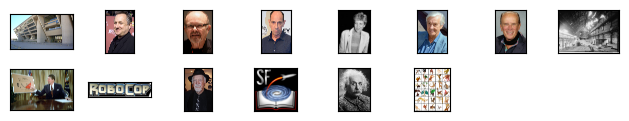

In [23]:
def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()

plot_images(image_metadata_dict)

### Build a separate CLIP image embedding index under a differnt collection `wikipedia_img`

In [ ]:
## ???

# def plot_images(image_paths):
#     images_shown = 0
#     plt.figure(figsize=(16, 9))
#     for img_path in image_paths:
#         if os.path.isfile(img_path):
#             image = Image.open(img_path)

#             plt.subplot(2, 3, images_shown + 1)
#             plt.imshow(image)
#             plt.xticks([])
#             plt.yticks([])

#             images_shown += 1
#             if images_shown >= 9:
#                 break

## Get Multi-Modal retrieval results for some example queries

In [11]:
test_query = "what is the Labour Party?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

In [ ]:
retrieval_results # 3 texts and 5 images as solicited

[NodeWithScore(node=TextNode(id_='e3d0a698-5f3c-47ad-9a76-de42eb9319f7', embedding=None, metadata={'file_path': 'c:\\Users\\madeinweb\\Documents\\GitHub\\multimodal-RAG\\data_wiki\\Labour Party (UK).txt', 'file_name': 'Labour Party (UK).txt', 'file_type': 'text/plain', 'file_size': 48857, 'creation_date': '2024-10-29', 'last_modified_date': '2024-10-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8f328bbc-bdb5-435f-87be-9aa4cd02d742', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'c:\\Users\\madeinweb\\Documents\\GitHub\\multimodal-RAG\\data_wiki\\Labour Party (UK).txt', 'file_name': 'Labour Party (UK).txt', 'file_type': 'text/plain', 'file_size': 48857, 'creation_date': '2024-10-29', '

**Node ID:** e3d0a698-5f3c-47ad-9a76-de42eb9319f7<br>**Similarity:** 0.7018370142912099<br>**Text:** The Labour Party is a political party in the United Kingdom that sits on the centre-left of the political spectrum. In a broader sense, the party has been described as an alliance of social democra...<br>

**Node ID:** 522c8503-953b-4415-a64e-fa8b29acb0aa<br>**Similarity:** 0.6741657226243075<br>**Text:** Influenced by Anthony Crosland's book The Future of Socialism (1956), the circle around party leader Hugh Gaitskell felt that the commitment was no longer necessary. An attempt to remove Clause IV ...<br>

**Node ID:** 361521a4-7d02-419b-88af-c01639fa0ecd<br>**Similarity:** 0.6599775635035792<br>**Text:** In 1924, a brand-conscious Labour leadership had devised a competition, inviting supporters to design a logo to replace the 'polo mint' like motif that had previously appeared in party literature. ...<br>

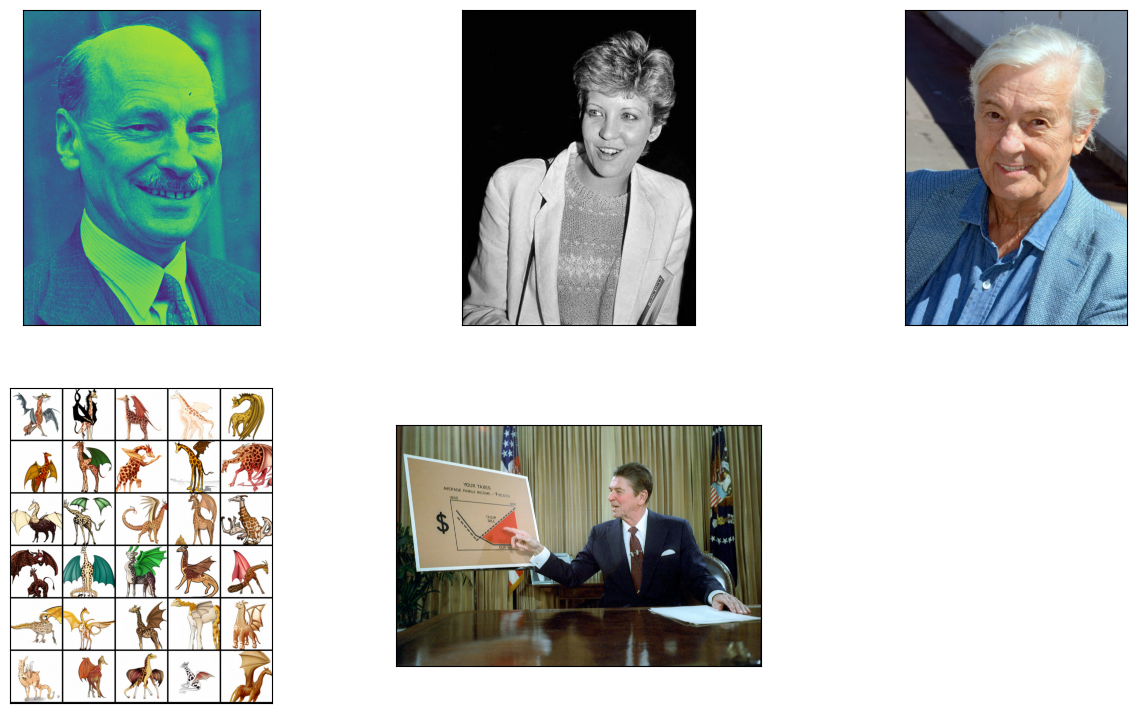

In [13]:
retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 2ab3c06d-bd14-49ba-b187-147abce84c3b<br>**Similarity:** 0.7340990285067811<br>**Text:** RoboCop is a 1987 American science fiction action film directed by Paul Verhoeven and written by Edward Neumeier and Michael Miner. The film stars Peter Weller, Nancy Allen, Daniel O'Herlihy, Ronny...<br>

**Node ID:** 5bc87c39-cf26-4dbe-a90c-0774c328b840<br>**Similarity:** 0.7309871071316864<br>**Text:** Angie Bolling and Jason Levine appear as Murphy's wife and son. RoboCop director Paul Verhoeven makes a cameo appearance as a dancing nightclub patron, producer Jon Davison provides the voice of ED...<br>

**Node ID:** 238ffe5b-ca5a-4c41-8b8c-54b1814f6895<br>**Similarity:** 0.7022798222692956<br>**Text:** The RoboCop character embodies the struggle of humanity to embrace technology. The central cast do not have romantic interests or overt sexual desires. Paul Sammon described the scene of RoboCop sh...<br>

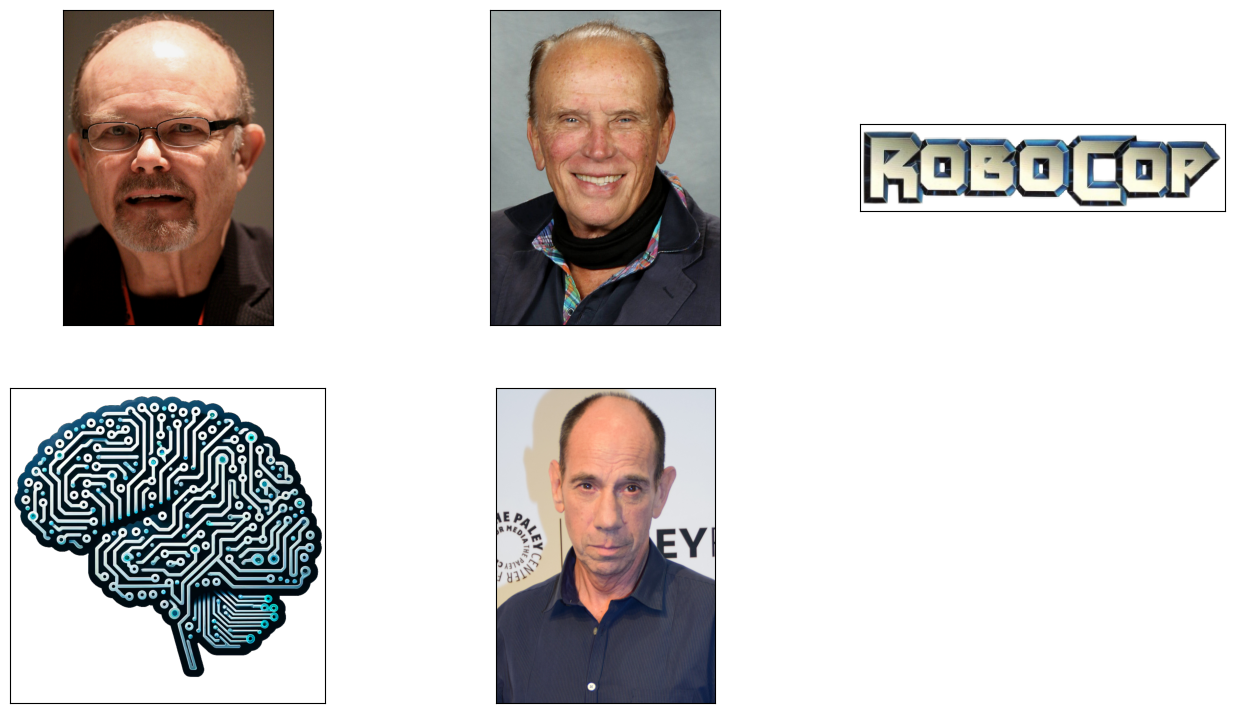

In [16]:
test_query = "Who created RoboCop?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** e39bb0f8-ebbd-4bb7-96e5-c3fc45fcd569<br>**Similarity:** 0.7197738557323874<br>**Text:** OpenAI is an American artificial intelligence (AI) research organization founded in December 2015 and headquartered in San Francisco, California. Its mission is to develop "safe and beneficial" art...<br>

**Node ID:** dac57a6b-4ce9-4973-a062-a9c3b0913518<br>**Similarity:** 0.7189216067054036<br>**Text:** OpenAI was initially run from Brockman's living room. It was later headquartered at the Pioneer Building in the Mission District, San Francisco.
According to Wired, Brockman met with Yoshua Bengio...<br>

**Node ID:** 0e6861bb-e0b6-4452-9599-cf1e3c4b7b98<br>**Similarity:** 0.704744140363053<br>**Text:** Altman stated that Y Combinator companies would share their data with OpenAI.


== Strategy ==
In the early years before his 2018 departure, Musk posed the question: "What is the best thing we ...<br>

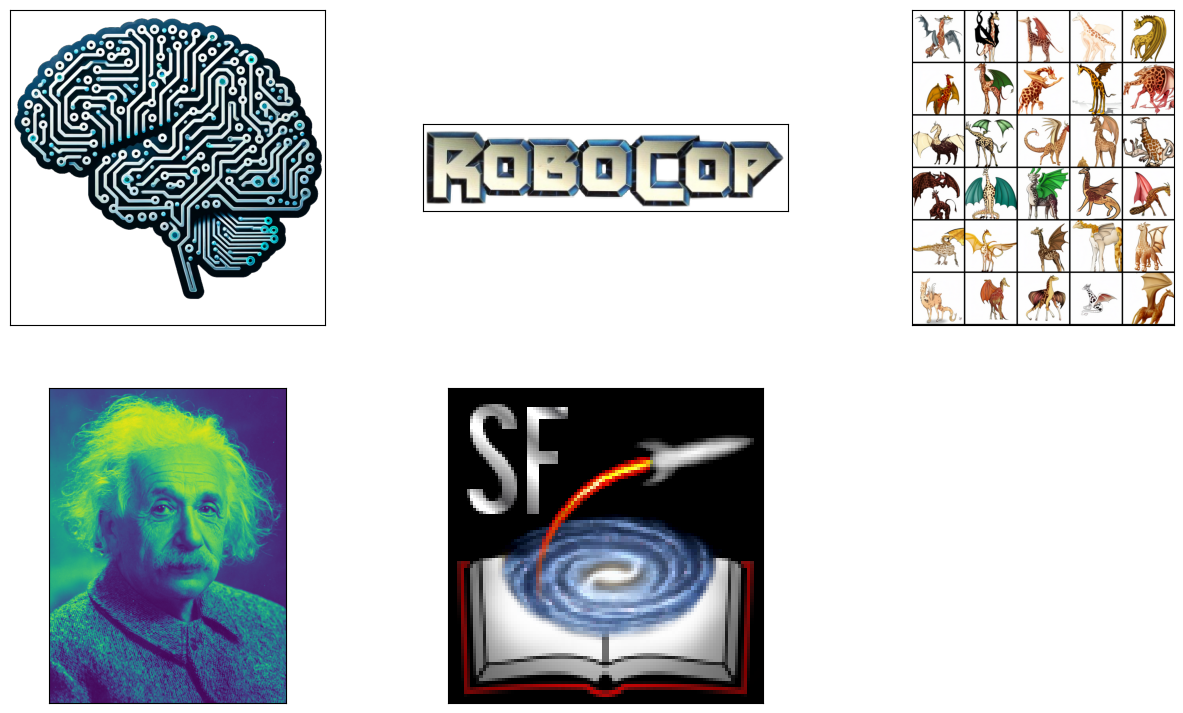

In [17]:
test_query = "What does OpenAI do?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** c2988931-d9ee-42d4-a34e-64ec2afd69e5<br>**Similarity:** 0.3772817685993902<br>**Text:** In June 2024, SpaceX introduced a compact version of its Starlink antennas, the "Starlink Mini," designed for mobile satellite internet use. Offered for $599 in an early access release, it was more...<br>

**Node ID:** 43f49dba-fece-472e-a602-74978f4df231<br>**Similarity:** 0.376978590992166<br>**Text:** Space Exploration Technologies Corp., commonly referred to as SpaceX, is an American space technology company. Since its founding in 2001, the company has made great advancement in rocket propulsio...<br>

**Node ID:** 3d0a5312-f71f-42d7-ada1-d738a6855929<br>**Similarity:** 0.37595679427141837<br>**Text:** According to NASA's own independently verified numbers, SpaceX's total development cost for the Falcon 9 rocket, including the Falcon 1 rocket, was estimated at $390 million. In 2011, NASA estimate...<br>

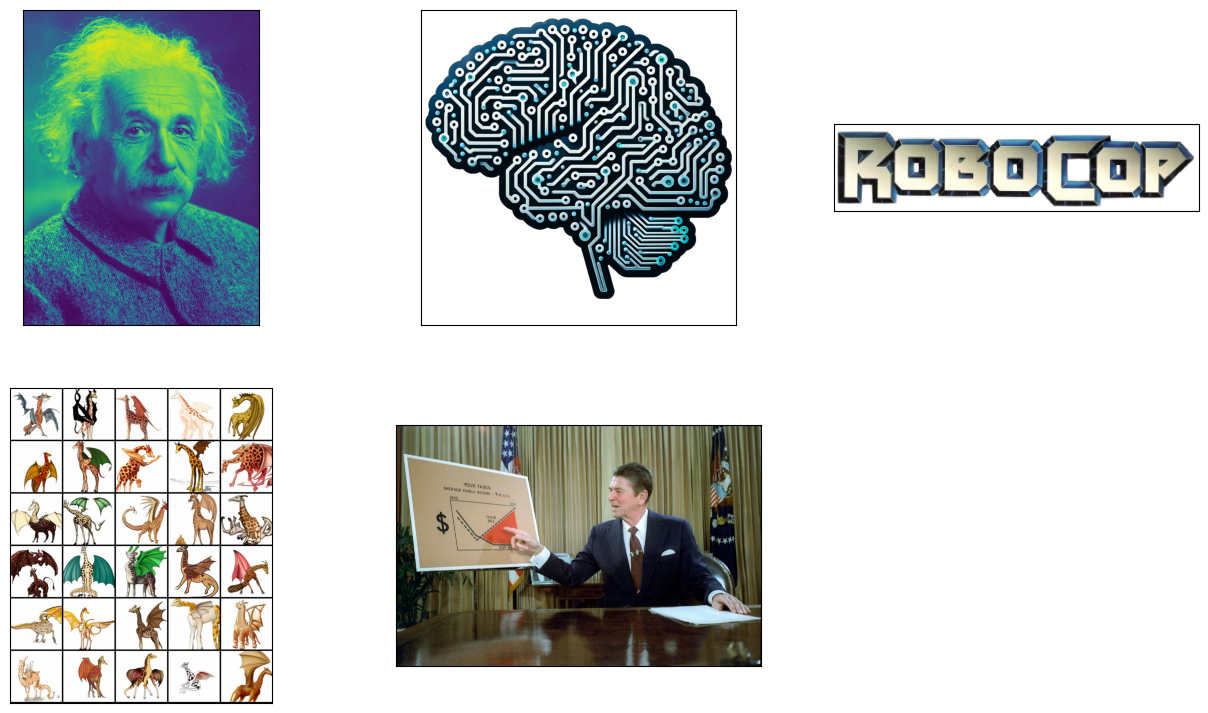

In [18]:
test_query = "which company makes Tesla"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)